In [5]:
## Load libraries

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.dates as mdates
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

# 1. Technical Analysis - LSTM model

In [7]:
ticker = 'aapl'

In [8]:
## 1.1. Load data and Remove Missing value
df = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_stock_Tech_data.csv')
df.set_index('Date', inplace=True)

df = df.dropna()
df.isnull().sum() 


## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close','Adj Close',
              'EMA5','EMA20','EMA60','EMA120','MA5','MA20','MA60','MA120',
              'BOL_H1', 'BOL_AVG', 'BOL_L1','BOL_H2','BOL_L2'
              ]
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label => numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) # 1-window size까지 feature에 추가 ... 를 반복
        label_list.append(label[i+window_size]) # window size + 1 번째는 label에 추가 ... 를 반복
    return np.array(feature_list), np.array(label_list) 

# feature_df, label_df 생성
feature_cols = ['Open', 'High', 'Low', 'Close','MA5','MA20','MA60','MA120',
              'EMA5','EMA20','EMA60','EMA120',
              'BOL_H1', 'BOL_AVG', 'BOL_L1','BOL_H2','BOL_L2']
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame => Numpy 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape) 

(2399, 17) (2399, 1)


In [9]:
## 3. Create data    
# 3.1. Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)
print(X.shape, Y.shape) # (2452, 50, 5) (2452, 1)

# 3.2. Split into train, test (split = int(len(X)*0.95))
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape) # (1961, 50, 5) (1961, 1)
print(x_test.shape, y_test.shape) # (491, 50, 5) (491, 1)


(2369, 30, 17) (2369, 1)
(1895, 30, 17) (1895, 1)
(474, 30, 17) (474, 1)


In [10]:
## 4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

# model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()



# 모델 학습 과정에서의 손실(loss) 값을 기록하기 위한 리스트
train_loss_history = []
val_loss_history = []

# model 학습 (checkpoint, earlystopping, reduceLR 적용)
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="jonghee_test/tech lstm_model.h5", monitor='val_loss', save_best_only=True) #가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10) #검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성하는 명령어입니다.

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=150,        # 100번 학습 - loss가 점점 작아진다, 만약 100번의 학습을 다 하지 않더라도 loss 가 더 줄지 않는다면, 맞춰둔 조건에 따라 조기종료가 이루어진다
          callbacks=[early_stop]) # save_best_only ,

pred = model.predict(x_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 40ms/step - loss: 0.1435 - mae: 0.0961 - val_loss: 0.1336 - val_mae: 0.1274
Epoch 2/100
13/13 [==============================] - 0s 24ms/step - loss: 0.1159 - mae: 0.0485 - val_loss: 0.1108 - val_mae: 0.0743
Epoch 3/100
13/13 [=

## Technical model Accuracy test

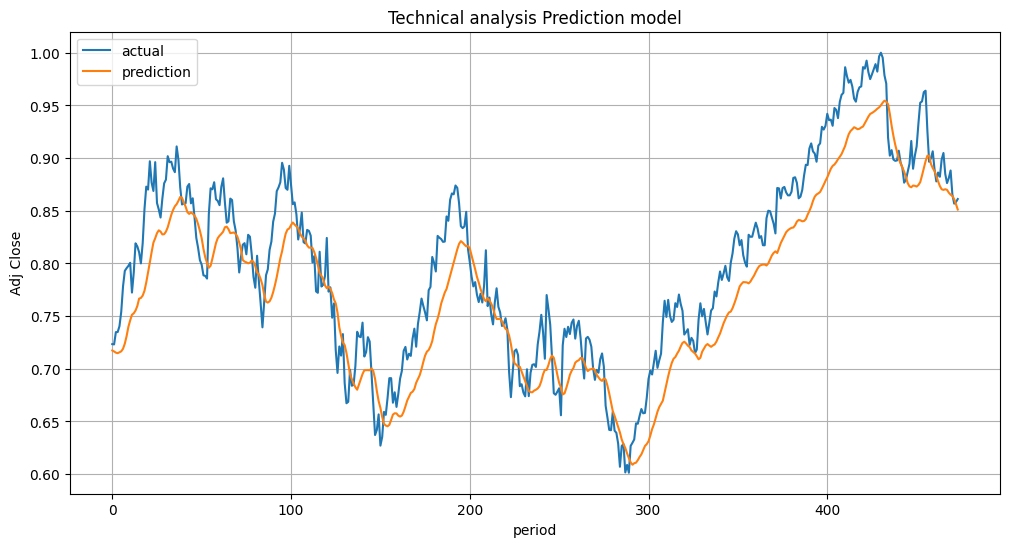

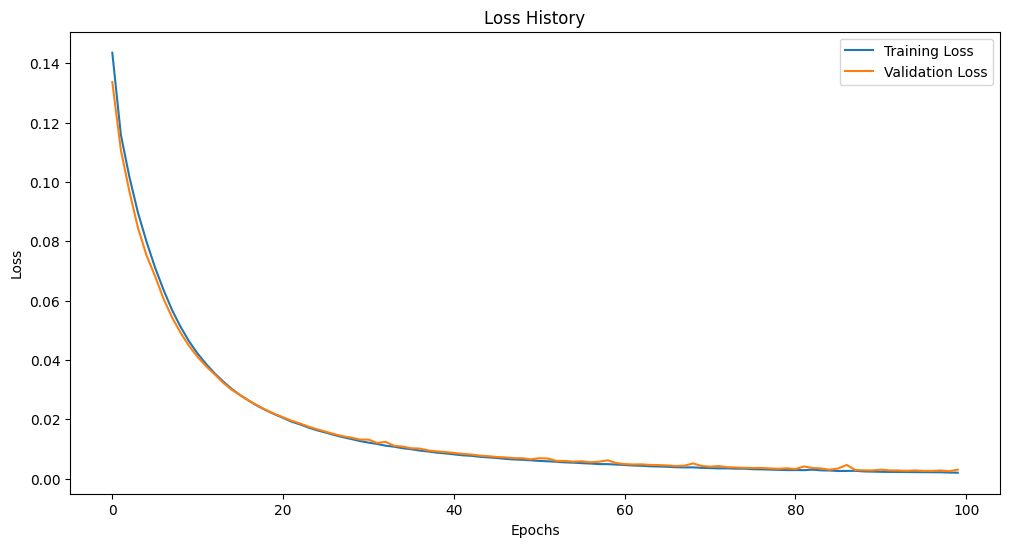

  Metrics    Values
0    MAPE  0.041138
1     MAE  0.033172
2    RMSE  0.039169


In [11]:
# 평가지표 1: 예측 그래프
plt.figure(figsize=(12, 6))
plt.title('Technical analysis Prediction model')
plt.ylabel('Adj Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# 평가지표 2: 학습곡선
train_loss_history.extend(hist.history['loss']) # 학습 과정에서의 손실값(로스) 기록
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# 평가지표 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)


## Stacking 모델의 인풋으로 사용하기 위한 데이터프레임화 + 실제 다음날 수정종가 예측하기

In [12]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) # y_test 역변환을 위한 임시 DataFrame
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() # pred 역변환을 위한 임시 DataFrame
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values # 해당 날짜 가져오기

tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 진짜 예측값 추출하기

last_date = pd.to_datetime(df.index[-1]) # df의 마지막 행의 날짜를 가져옴

if last_date.weekday() == 4:  # 0: 월요일, 1: 화요일, ..., 4: 금요일
    next_day = last_date + pd.Timedelta(days=3)  # 금요일에서 3일 후는 월요일
else:
    next_day = last_date + pd.Timedelta(days=1)  # 그 외의 경우에는 하루를 더함


# 1. Extract the last 50 days data
recent_feature = feature_np[-window_size:]
recent_feature = recent_feature.reshape(1, window_size, -1)

# 2. Predict the value for the next day
predicted_new = model.predict(recent_feature)

# 3. Inverse transform the predicted value to its original scale
dummy_data = np.zeros((1, scaled_df.shape[1] - 1))
predicted_new_full_features = np.hstack([predicted_new, dummy_data])

tech_predicted_new_original = scaler.inverse_transform(predicted_new_full_features)[0, 0]


1/1 [==============================] - 0s 11ms/step


# 2. Fundamental Analysis - LSTM model

In [13]:
## 1.1. Load data
df = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_FS_summary.csv')
df2 = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/Econ_data.csv')
df3 = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/Industry_data.csv')


df.set_index('Date', inplace=True)
df2.set_index('Date', inplace=True)
df3.set_index('Date', inplace=True)


# 1.2. Select the required columns from df2
df2_selected = df2[['GDP', 'CPIAUCSL']].copy()
df3_selected = df3[['NDAQ Adj Close', 'DJI Adj Close', 'SPX Adj Close'] + [df3.columns[-2]]]

# 1.3. Merge the selected data with df based on the Date
df = df.merge(df2_selected, on='Date', how='left')
df = df.merge(df3_selected, on='Date', how='left')

## 2.1. Remove Outliers & Missing value
df = df.dropna()
df.isnull().sum() 

## 2.2. Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label => numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) # 1-window size까지 feature에 추가 ... 를 반복
        label_list.append(label[i+window_size]) # window size + 1 번째는 label에 추가 ... 를 반복
    return np.array(feature_list), np.array(label_list) 

# feature_df, label_df 생성
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame => Numpy 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape) # (2353, 16) (2353, 1)

   
## 3. Create data    
# 3.1. Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)
print(X.shape, Y.shape) # (2452, 50, 5) (2452, 1)

# 3.2. Split into train, test (split = int(len(X)*0.95))
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape) # (1961, 50, 5) (1961, 1)
print(x_test.shape, y_test.shape) # (491, 50, 5) (491, 1)

(2518, 27) (2518, 1)
(2488, 30, 27) (2488, 1)
(1990, 30, 27) (1990, 1)
(498, 30, 27) (498, 1)


In [14]:
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape, return_sequences=True,
               kernel_regularizer=L1L2(l1=0.001, l2=0.001), recurrent_regularizer=L1L2(l1=0.001, l2=0.001)))
               
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])


model.summary()



# 모델 학습 과정에서의 손실(loss) 값을 기록하기 위한 리스트
train_loss_history = []
val_loss_history = []

# model 학습 (checkpoint, earlystopping, reduceLR 적용)
# save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="jonghee_test/tech lstm_model.h5", monitor='val_loss', save_best_only=True) #가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10) #검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성하는 명령어입니다.

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=150,        # 100번 학습 - loss가 점점 작아진다, 만약 100번의 학습을 다 하지 않더라도 loss 가 더 줄지 않는다면, 맞춰둔 조건에 따라 조기종료가 이루어진다
          callbacks=[early_stop]) # save_best_only ,

pred = model.predict(x_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           79872     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129345 (505.25 KB)
Trainable params: 129345 (505.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
14

## Fundamental model Accuracy test

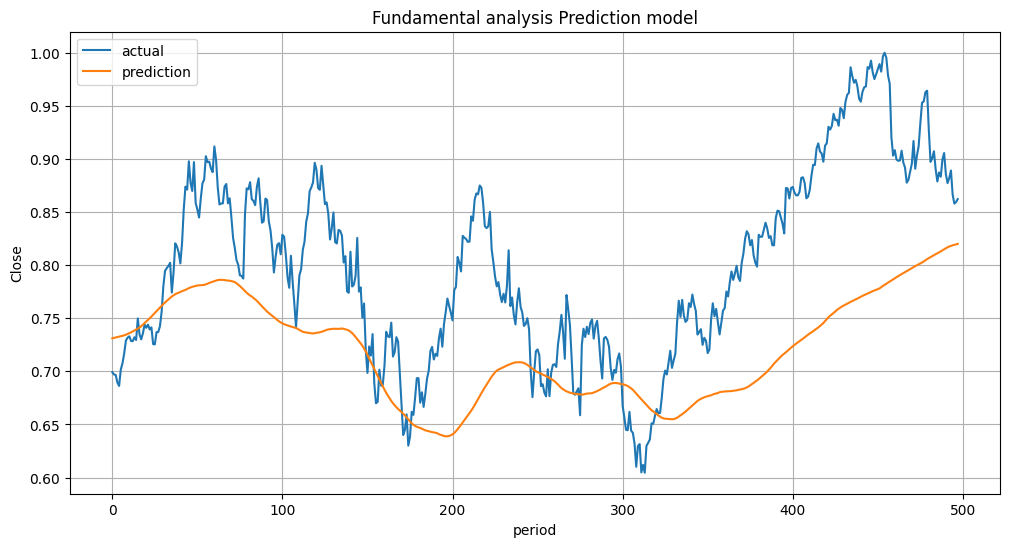

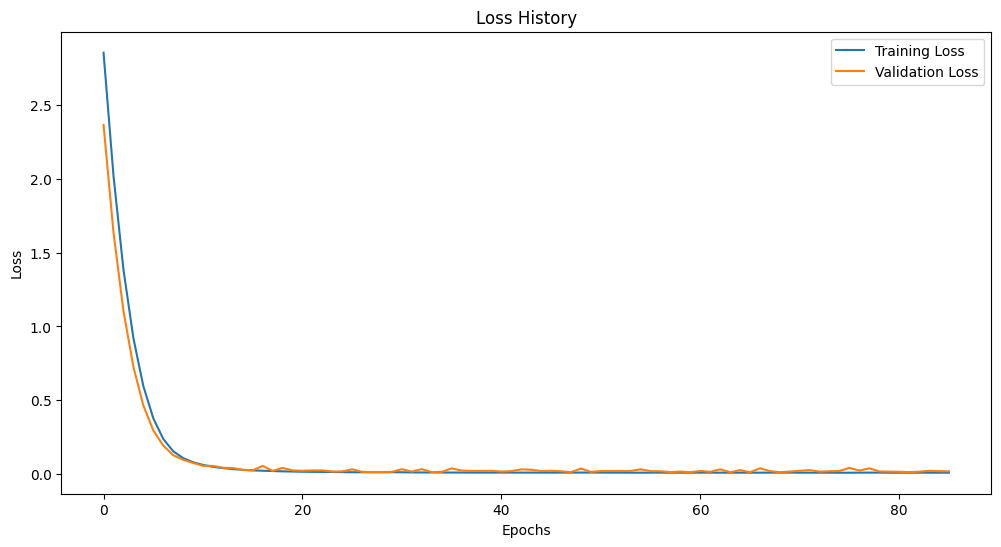

  Metrics    Values
0    MAPE  0.099517
1     MAE  0.083442
2    RMSE  0.100751


In [15]:
# 평가지표 1: 예측 그래프
plt.figure(figsize=(12, 6))
plt.title('Fundamental analysis Prediction model')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# 평가지표 2: 학습곡선
train_loss_history.extend(hist.history['loss']) # 학습 과정에서의 손실값(로스) 기록
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# 평가지표 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## Stacking 모델의 인풋으로 사용하기 위한 데이터프레임화 + 실제 다음날 수정종가 예측하기

In [16]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) # y_test 역변환을 위한 임시 DataFrame
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() # pred 역변환을 위한 임시 DataFrame
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values # 해당 날짜 가져오기

fund_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 진짜 예측값 추출하기

last_date = pd.to_datetime(df.index[-1]) # df의 마지막 행의 날짜를 가져옴

if last_date.weekday() == 4:  # 0: 월요일, 1: 화요일, ..., 4: 금요일
    next_day = last_date + pd.Timedelta(days=3)  # 금요일에서 3일 후는 월요일
else:
    next_day = last_date + pd.Timedelta(days=1)  # 그 외의 경우에는 하루를 더함


# 1. Extract the last 50 days data
latest_data = feature_np[-window_size:]
latest_data = latest_data.reshape(1, window_size, -1)

# 2. Predict the value for the next day
next_day_pred = model.predict(latest_data)

# 3. Inverse transform the predicted value to its original scale
inverse_df_temp = pd.DataFrame(np.zeros((1, len(scale_cols))), columns=scale_cols)  # 역변환을 위한 임시 DataFrame
inverse_df_temp['Adj Close'] = next_day_pred.flatten()
fund_predicted_new_original = scaler.inverse_transform(inverse_df_temp)[:, inverse_df_temp.columns.get_loc('Adj Close')]

# Convert numpy array value to scalar
fund_predicted_new_original = fund_predicted_new_original.item()

1/1 [==============================] - 0s 11ms/step


# 3. XGBoost를 이용한 Stacking model

In [17]:
df = pd.merge(tech_result_df[['Date', 'Real Price', 'Predicted Price']], 
                     fund_result_df[['Date', 'Predicted Price']],
                     on='Date', 
                     how='inner', 
                     suffixes=('_Tech', '_Fund'))

df.columns = ['Date', 'Real Price', 'Tech_Pred', 'Fund_Pred'] # Rename Column
df = df.set_index('Date').sort_index()


In [18]:
# MinMax
scaler = MinMaxScaler()
scale_cols = ['Real Price', 'Tech_Pred', 'Fund_Pred']
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

print(scaled_df)

# 2. Create Feature/Label for Stacking model
X_stack = scaled_df[['Tech_Pred', 'Fund_Pred']].values
y_stack = scaled_df['Real Price'].values

# Data split (20% test)
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.2, random_state=42)


     Real Price  Tech_Pred  Fund_Pred
0      0.306192   0.313867   0.632046
1      0.305502   0.311158   0.641381
2      0.334775   0.307863   0.650594
3      0.334913   0.306427   0.659390
4      0.348722   0.309078   0.669475
..          ...        ...        ...
469    0.719580   0.741930   0.989315
470    0.662115   0.738301   0.992559
471    0.640775   0.729345   0.994830
472    0.644401   0.715839   0.997341
473    0.651654   0.701046   1.000000

[474 rows x 3 columns]


In [19]:
# 3. Meta model training using XGBoost with GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror')


param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with best parameters
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
meta_model_xgb.fit(X_train, y_train)

y_pred = meta_model_xgb.predict(X_val)



Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.8}


# 비주얼

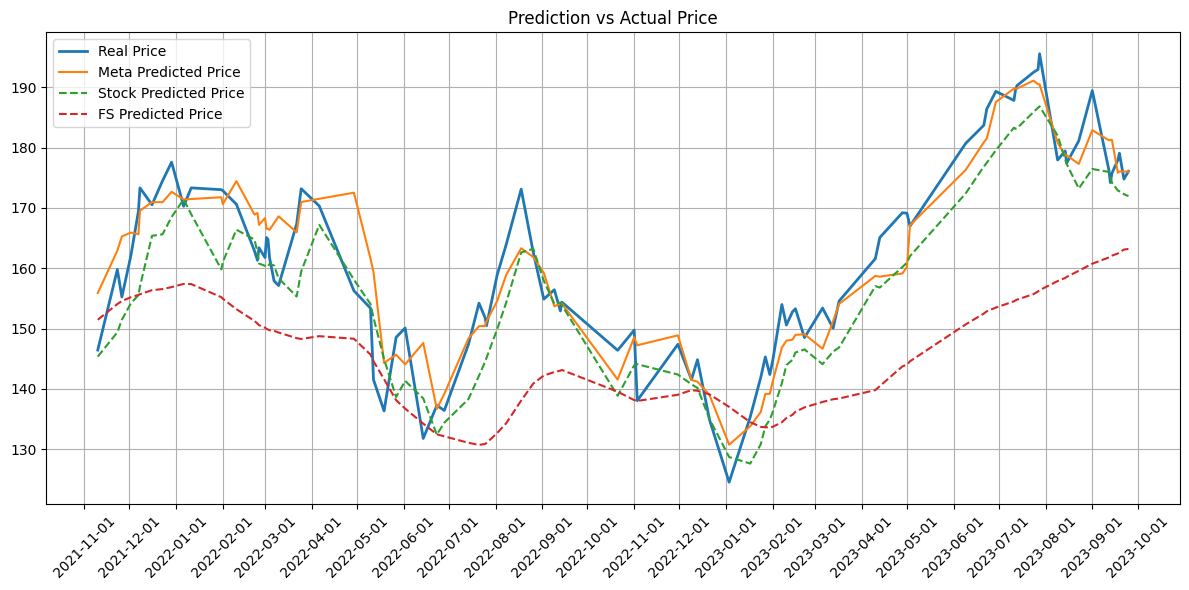

In [20]:
# 스케일링된 데이터에서 예측값 추출
y_val_original = scaler.inverse_transform(np.column_stack([y_val, np.zeros_like(y_val), np.zeros_like(y_val)]))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack([y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)]))[:, 0]
tech_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), X_val[:, 0], np.zeros_like(y_pred)]))[:, 1]
fund_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), np.zeros_like(y_pred), X_val[:, 1]]))[:, 2]

# 날짜 데이터 추출
date_train, date_val = train_test_split(df.index, test_size=0.2, random_state=42)

# 그래프 그리기 준비
plot_df = pd.DataFrame({
    'Date': date_val,
    'Real Price': y_val_original,
    'Meta Predicted Price': y_pred_original,
    'Stock Predicted Price': tech_pred_original,
    'FS Predicted Price': fund_pred_original
})

# 날짜를 기준으로 정렬
plot_df = plot_df.sort_values(by='Date')
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Real Price'], label='Real Price', linewidth=2)
plt.plot(plot_df['Date'], plot_df['Meta Predicted Price'], label='Meta Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['Stock Predicted Price'], '--', label='Stock Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['FS Predicted Price'], '--', label='FS Predicted Price', linewidth=1.5)

ax = plt.gca() # X축의 라벨 간격 설정
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1개월 간격으로 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 설정

plt.title("Prediction vs Actual Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # X축 라벨 45도로 기울이기
plt.tight_layout()  # 그래프가 잘 보이도록 레이아웃 조정
plt.show()


## 정확도 평가

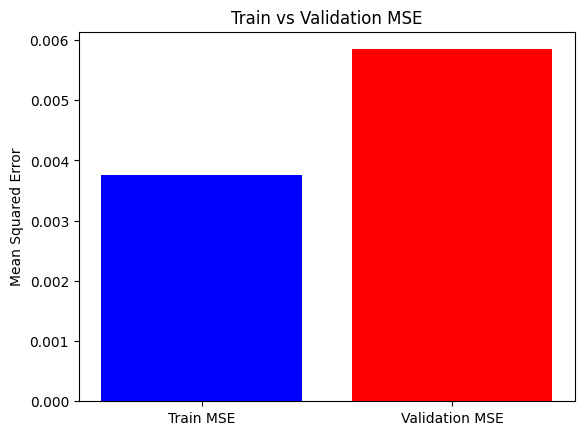

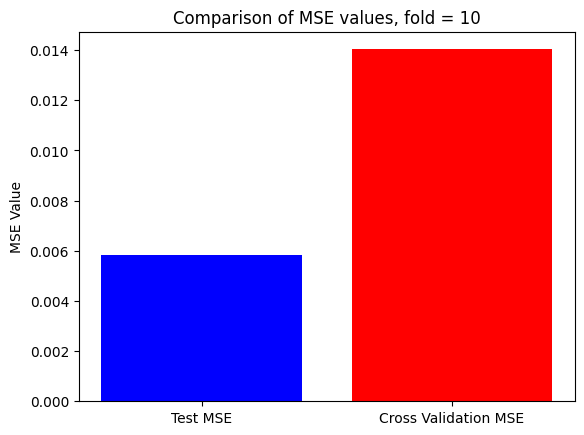

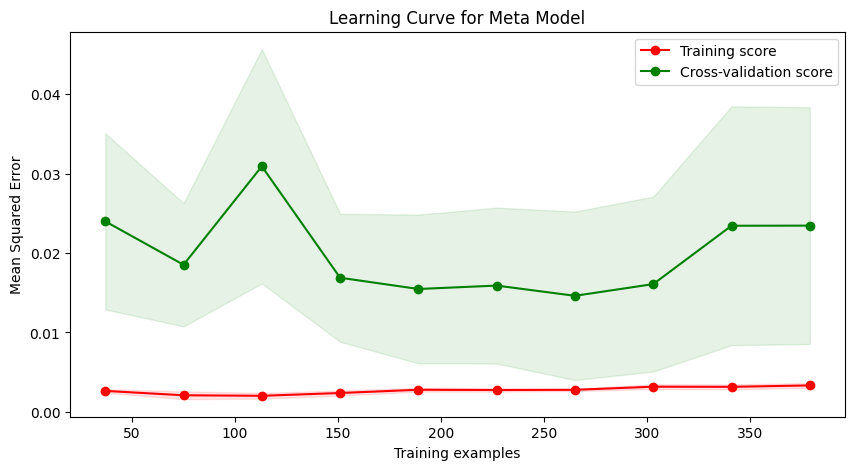

In [21]:
# 1. MSE 비교 그래프
y_train_pred = meta_model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_pred)

plt.bar(['Train MSE', 'Validation MSE'], [train_mse, val_mse], color=['blue', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.show()


# 2. 교차 검증
cross_val_mse = -cross_val_score(meta_model_xgb, X_stack, y_stack, cv=10, scoring='neg_mean_squared_error').mean()
errors = [val_mse, cross_val_mse]
labels = ['Test MSE', 'Cross Validation MSE']

plt.bar(labels, errors, color=['blue', 'red'])
plt.ylabel('MSE Value')
plt.title('Comparison of MSE values, fold = 10')
plt.show()



## 3. 학습 곡선 (임의)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve( # 학습 곡선 데이터 얻기
    meta_model_xgb, X_stack, y_stack, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring="neg_mean_squared_error"
)

train_scores_mean = -train_scores.mean(axis=1) # 평균 및 표준 편차 계산
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 5))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.title("Learning Curve for Meta Model")
plt.show()


## 실제 다음날 예측

In [22]:
# Tech와 Fund 모델로부터 얻은 다음 날의 예측 값을 표현하자면 다음과 같습니다:
next_day_tech_pred = tech_predicted_new_original  # 여기에 Tech 모델로부터 얻은 다음 날 예측 값을 넣어주세요.
next_day_fund_pred = fund_predicted_new_original  # 여기에 Fund 모델로부터 얻은 다음 날 예측 값을 넣어주세요.

# 이 값을 스케일링 합니다:
next_day_tech_pred_scaled = scaler.transform([[0, next_day_tech_pred, 0]])[0][1]  # 가격 부분만 스케일링
next_day_fund_pred_scaled = scaler.transform([[0, 0, next_day_fund_pred]])[0][2]  # 가격 부분만 스케일링

# 스택킹 모델을 사용하여 예측합니다:
next_day_meta_pred_scaled = meta_model_xgb.predict(np.array([[next_day_tech_pred_scaled, next_day_fund_pred_scaled]]))[0]

# 예측 값을 원래의 스케일로 변환합니다:
next_day_meta_pred = scaler.inverse_transform([[next_day_meta_pred_scaled, 0, 0]])[0][0]

last_date = pd.to_datetime(df.index[-1]) # df의 마지막 행의 날짜를 가져옴

if last_date.weekday() == 4:  # 0: 월요일, 1: 화요일, ..., 4: 금요일
    next_day = last_date + pd.Timedelta(days=3)  # 금요일에서 3일 후는 월요일
else:
    next_day = last_date + pd.Timedelta(days=1)  # 그 외의 경우에는 하루를 더함

print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Tech 예측 가격은: {tech_predicted_new_original}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Funda 예측 가격은: {fund_predicted_new_original}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 최종 예측 가격은: {next_day_meta_pred}") 

다음 날(2023-10-02)의 Tech 예측 가격은: 169.34796678990827
다음 날(2023-10-02)의 Funda 예측 가격은: 163.63823636058007
다음 날(2023-10-02)의 최종 예측 가격은: 175.09426595439615


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
